In [1]:
## Kalau kerjakan di google colab, install dulu emcee dan corner
# !pip install -U emcee
# !pip install corner

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import emcee
import corner
from scipy import stats

### util functions

In [3]:
def plot_chain(labels, sampler, figsize=(10, 4), alpha=0.5, thin=1):
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=figsize, sharex=True)
    axes = np.atleast_1d(axes)
    samples = sampler.get_chain(thin=thin)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
    fig.show()

In [4]:
def sampled(theta, M):
    L, _ = theta.shape
    indices = np.random.choice(L, size=M, replace=True)
    samples = theta[indices, :]
    return samples

# 1. Sampel acak

Tinjau sebuah galaksi yang memiliki distribusi kerapatan jumlah berikut dalam koordinat
silinder:
\begin{align*}
    n(r, z) = n_0 \textrm{ sech}\left(\frac{r}{r_0}\right) \exp\left(-\frac{|z|}{z_0}\right) 
\end{align*}

maka bisa ditebak bahwa (rapat) probabilitas menemukan bintang pada $z$ dan $r$ adalah
\begin{align*}
    P(r, z) \propto n(r, z)
\end{align*}

Misalkan galaksi tersebut memiliki $n_0 = 1$ $\textrm{pc}^{-3}$, $r_0 = 10$ kpc, dan $z_0 = 1$ kpc.

Ambil sampel acak dari distribusi ini dengan menggunakan metode MCMC sebanyak
10000 sampel. Buat plot 3D dan plot 2D untuk proyeksi bidang XY, XZ, dan YZ dari sampel yang dihasilkan.


# 2. Fit Bintang Variabel

Diberikan data magnitudo dan waktu pengamatan dari sebuah bintang variabel.

In [5]:
t = np.loadtxt('data/DTVir.txt', usecols=0) # waktu dalam hari
m = np.loadtxt('data/DTVir.txt', usecols=1) # magnitudo
merr = np.repeat(0.01, len(m)) # error magnitudo

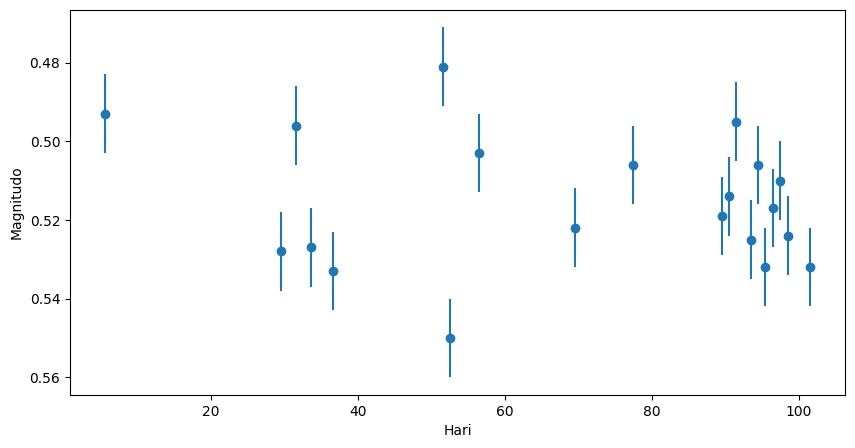

In [6]:
plt.figure(figsize=(10,5))
plt.errorbar(t, m, yerr=merr, fmt='o')
plt.xlabel('Hari')
plt.ylabel('Magnitudo')
plt.gca().invert_yaxis()
plt.show()

Modelkan variabilitas magnitudo sebagai fungsi sinusoidal berikut:
\begin{align*}
    m(t) = A \sin\left(\frac{2\pi}{P} t +\phi \right) + m_0
\end{align*}

Tentukan nilai parameter $A$, $P$, $\phi$, dan $m_0$ dengan melakukan fit data.
Tentukan pula ketidakpastian dari masing-masing parameter.

# 3. Fit Variasi Kecepatan Radial Bintang

Diberikan data kecepatan radial bintang yang diduga memiliki sebuah planet. Data kecepatan radial sudah dikoreksi terhadap efek kecepatan pengamat di tata surya.

In [7]:
t = np.loadtxt('data/Pr211.txt', usecols=0) # waktu dalam hari
t -= t[0] # relatifkan terhadap waktu pertama
vr = np.loadtxt('data/Pr211.txt', usecols=1) # kecepatan radial dalam km/s
vrerr = np.loadtxt('data/Pr211.txt', usecols=2) # error kecepatan radial dalam km/s

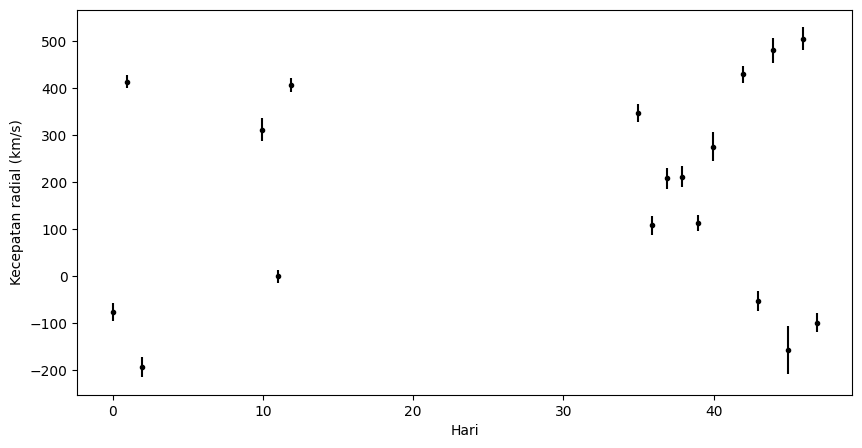

In [8]:
plt.figure(figsize=(10,5))
plt.errorbar(t, vr, yerr=vrerr, fmt='.', c='k')
plt.xlabel('Hari')
plt.ylabel('Kecepatan radial (km/s)')
plt.show()

Modelkan variasi kecepatan radial sebagai fungsi sinusoidal berikut:
\begin{align}
    v(t) = K \sin\left(\frac{2\pi}{P} t + \phi\right)+ v_0
\end{align}

Tentukan nilai parameter $K$, $P$, $\phi$, dan $v_0$ dengan melakukan fit data.
Tentukan pula ketidakpastian dari masing-masing parameter.

# 4. Jarak ke gugus bintang

Diberikan data koordinat bintang-bintang $(\alpha, \delta)$, paralaks $\varpi\pm \sigma_{\varpi}$, dan kecepatan gerak diri $(\mu_\alpha, \mu_\delta)$ dari sebuah gugus bintang.

In [9]:
data_raw = pd.read_csv('data/gdr1set03.csv')
data_raw

,ra,dec,parallax,parallax_error,pmra,pmdec
0,55.879796,22.158187,7.418107,0.240476,19.719670,-45.481206
1,54.637015,21.284088,9.081912,0.388545,20.792591,-44.517357
2,57.588858,23.096158,7.200001,0.605311,20.868535,-46.429938
3,56.613754,24.254813,7.743384,0.322796,19.955615,-44.291813
4,56.046827,23.379132,7.998248,0.295432,22.119289,-46.981271
...,...,...,...,...,...,...
159,55.012941,27.740329,7.127912,0.256618,21.010751,-44.370785
160,56.364845,28.668498,8.444300,0.508478,22.070279,-50.010506
161,52.890208,26.265290,7.055644,0.283516,20.811421,-42.116779
162,56.496509,25.398403,7.569175,0.342092,20.288465,-45.366802


Misalkan *likelihood* dari gugus bintang ini adalah:
\begin{align*}
    P(\{\varpi\}|\{\sigma_{\varpi}\}, r_c, s_c) = \prod_{i}^{N}\int \frac{1}{\sqrt{2\pi}\sigma_{\varpi,i}}\exp\left[-\frac{\left(\varpi_i-1/r_i\right)^2}{2\sigma_{\varpi,i}^2}\right]
    \frac{1}{\sqrt{2\pi}s_c}\exp\left[-\frac{\left(r_i-r_c\right)^2}{2s_c^2}\right]\mathrm{d}r_i
\end{align*}

Dengan posterior sebagai berikut:
\begin{align*}
    P(r_c, s_c|\{\varpi\}, \{\sigma_{\varpi}\}) \propto P(\{\varpi\}|\{\sigma_{\varpi}\}, r_c, s_c) P_0(r_c)P_0(s_c)
\end{align*}

Dengan $\varpi$ adalah paralaks dan $\sigma_{\varpi}$ adalah ketidakpastian paralaks dalam satuan milidetik busur, serta $r,r_c,s_c$ dalam satuan $\textrm{kpc}$.

dan $P_0(r_c)$ adalah prior jarak gugus bintang dan $P_0(s_c)$ adalah prior ukuran gugus.